#### Diffusion Model 
Diffusion model with variational Autoencoder. With the help of data augmentation, increasing the number of trainable datapoint.  

This notebook contains the same diffusionmodel with a bit change in the architecture. 

In [ ]:
# # To use the CPU only
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Use CPU only

In [1]:
# Required packages
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
## Import Required Libraries for data Generator 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# To clear out the gpu memory
import tensorflow as tf
tf.keras.backend.clear_session()

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [3]:
# list out all the number of GPUs available on the systtem
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
# Load and preprocess data (replace with your own data loading)
fileIN = '../jet_notebooks/Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5'
f = h5py.File(fileIN)
# Load and preprocess data (replace with your data loading)
# Assuming you have jet images in a numpy array 'jet_images'
# Normalize the pixel values between 0 and 1
jet_images = np.array(f.get('jetImage')).astype('float32') / 255.0
dataset_shape = jet_images.shape
image_size = dataset_shape[1]

In [5]:
# Data Augmentation
# Create Data Generators:
# Define data augmentation settings
data_augmentation = ImageDataGenerator(
    rotation_range=20,      # Random rotation between -20 and 20 degrees
    width_shift_range=0.1,  # Random horizontal shift by 10% of image width
    height_shift_range=0.1, # Random vertical shift by 10% of image height
    shear_range=0.2,        # Random shear transformation
    zoom_range=0.2,         # Random zoom between 80% and 120% of original size
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill newly created pixels with nearest neighbors
)



In [6]:
# Add noise to the images
noise_factor = 0.5
noisy_jet_images = jet_images + noise_factor * np.random.normal(size=jet_images.shape)


In [7]:
# Reshape the jet images dataset to match the model's input shape
jet_images_reshaped = jet_images.reshape((-1, image_size, image_size, 1))
noisy_jet_images_reshaped = noisy_jet_images.reshape((-1, image_size, image_size, 1))


In [8]:
# Create data generators for noisy and clean images
batch_size = 32
train_noisy_datagen = data_augmentation.flow(noisy_jet_images_reshaped, batch_size=batch_size, shuffle=True)
train_clean_datagen = data_augmentation.flow(jet_images_reshaped, batch_size=batch_size, shuffle=True)


###  Issues:
    1. Validation loss falls sharply while the training loss falls smoothly. 
---
    -> Trying to reduce the model complexity
    2. There are another methods which we can implement:
        1. Reduce Model Complexity: 
        2. Regularization Techniques
        3. Data Augmentation
        4. Early Stopping
        5. Validation Data
        6. Learning Rate Schedule
        7. Different Architecture
        8. More Datas
        9. Batch Normalization
        10. Early Stopping

In [9]:
# Define the autoencoder architecture for denoising 
input_img = Input(shape=(image_size, image_size, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)  # Add BatchNormalization layer
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)  # Add BatchNormalization layer
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)  # Add BatchNormalization layer
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)  # Add BatchNormalization layer
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')


In [11]:
# # Train the autoencoder
# history = autoencoder.fit(noisy_jet_images_reshaped, jet_images_reshaped,
#                           epochs=5,
#                           batch_size=64,
#                           shuffle=True,
#                           validation_split=0.1)


In [12]:
# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [13]:
# Training the autoencoder with the genrated data or the augmented data
history = autoencoder.fit_generator(
    zip(train_noisy_datagen, train_clean_datagen),
    steps_per_epoch=len(noisy_jet_images_reshaped) // batch_size,
    epochs=50,
    validation_data=(noisy_jet_images_reshaped, jet_images_reshaped), 
    callbacks=[early_stopping]
)


Epoch 1/50


/tmp/sraj/ipykernel_411567/2041531694.py:2: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(


312/312 [==============================] - ETA: 0s - batch: 155.5000 - size: 32.0000 - loss: 0.1551

/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


312/312 [==============================] - 25s 66ms/step - batch: 155.5000 - size: 32.0000 - loss: 0.1551 - val_loss: 0.9993
Epoch 2/50
312/312 [==============================] - 20s 64ms/step - batch: 155.5000 - size: 31.9487 - loss: 0.0560 - val_loss: 0.0028
Epoch 3/50
312/312 [==============================] - 20s 64ms/step - batch: 155.5000 - size: 31.9487 - loss: 0.0297 - val_loss: 0.0020
Epoch 4/50
312/312 [==============================] - 20s 64ms/step - batch: 155.5000 - size: 31.9487 - loss: 0.0174 - val_loss: 0.0010
Epoch 5/50
312/312 [==============================] - 20s 64ms/step - batch: 155.5000 - size: 31.9487 - loss: 0.0104 - val_loss: 0.0011
Epoch 6/50
312/312 [==============================] - 20s 64ms/step - batch: 155.5000 - size: 31.9487 - loss: 0.0054 - val_loss: 7.4101e-04
Epoch 7/50
312/312 [==============================] - 20s 65ms/step - batch: 155.5000 - size: 31.9487 - loss: 0.0036 - val_loss: 7.1829e-04
Epoch 8/50
312/312 [==============================]

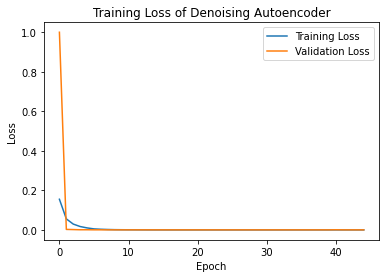

In [15]:
# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss of Denoising Autoencoder')
plt.legend()
plt.show()

/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


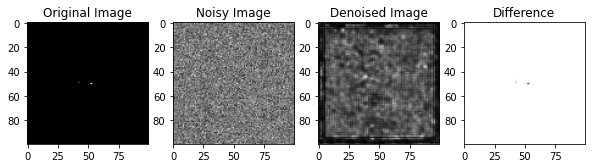

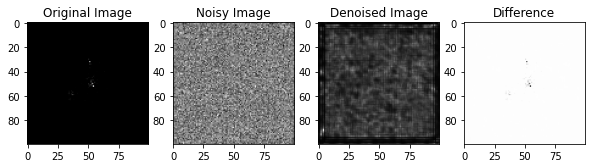

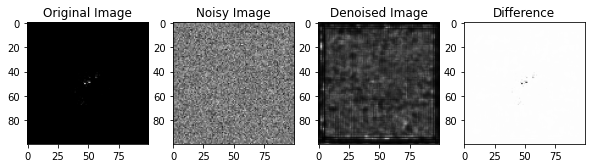

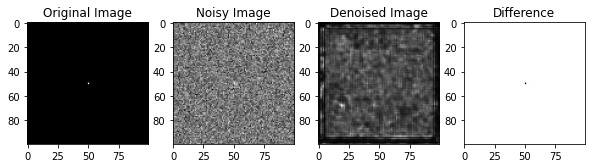

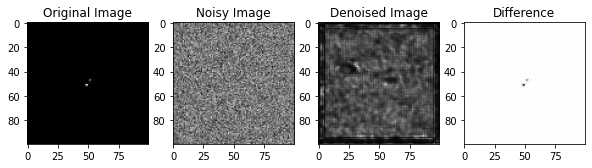

In [16]:

# Denoise some sample images
num_samples = 5
sample_indices = np.random.randint(0, len(noisy_jet_images_reshaped), num_samples)
sample_noisy_images = noisy_jet_images_reshaped[sample_indices]
sample_denoised_images = autoencoder.predict(sample_noisy_images)

# Display original, noisy, and denoised images
for i in range(num_samples):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 4, 1)
    plt.imshow(jet_images_reshaped[sample_indices[i]].reshape((image_size, image_size)), cmap='gray')
    plt.title('Original Image')
    
    plt.subplot(1, 4, 2)
    plt.imshow(noisy_jet_images_reshaped[sample_indices[i]].reshape((image_size, image_size)), cmap='gray')
    plt.title('Noisy Image')
    
    plt.subplot(1, 4, 3)
    plt.imshow(sample_denoised_images[i].reshape((image_size, image_size)), cmap='gray')
    plt.title('Denoised Image')
    
    plt.subplot(1, 4, 4)
    plt.imshow(sample_denoised_images[i].reshape((image_size, image_size)) - 
               jet_images_reshaped[sample_indices[i]].reshape((image_size, image_size)), cmap='gray')
    plt.title('Difference')
    
    plt.show()

Adding colorbar to the above image

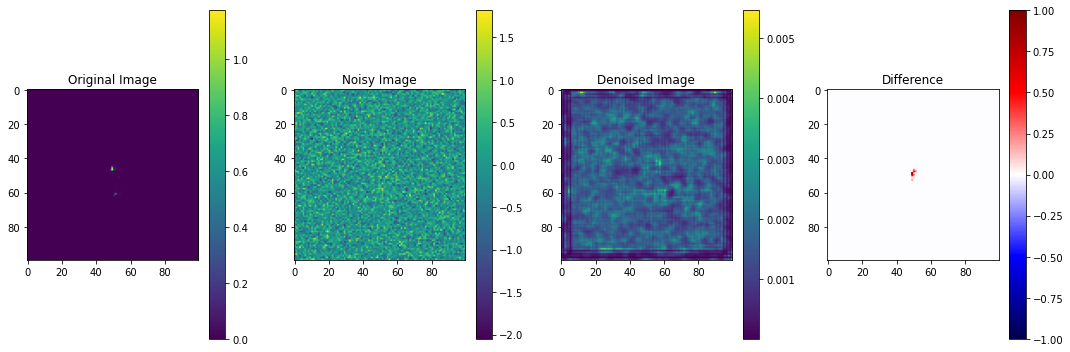

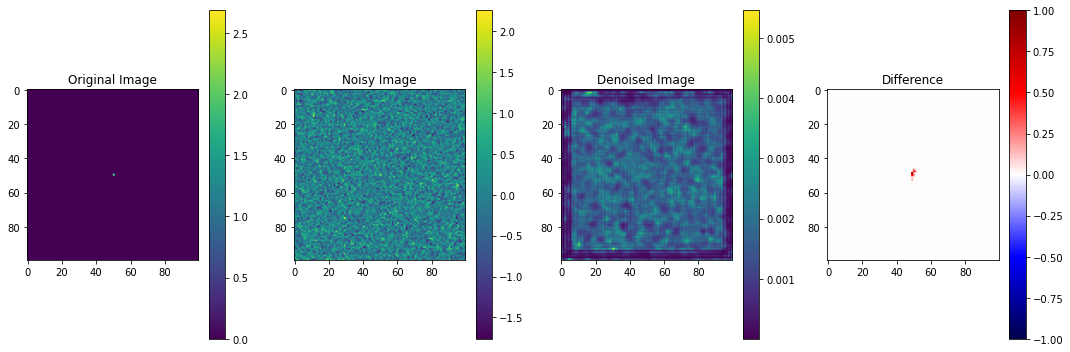

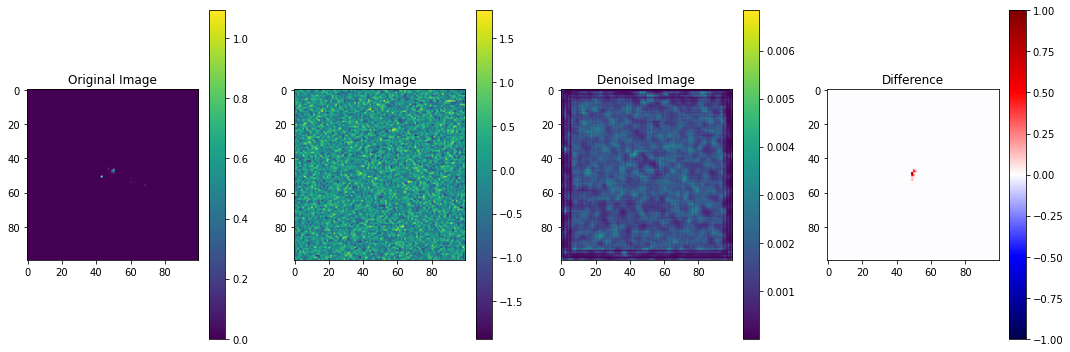

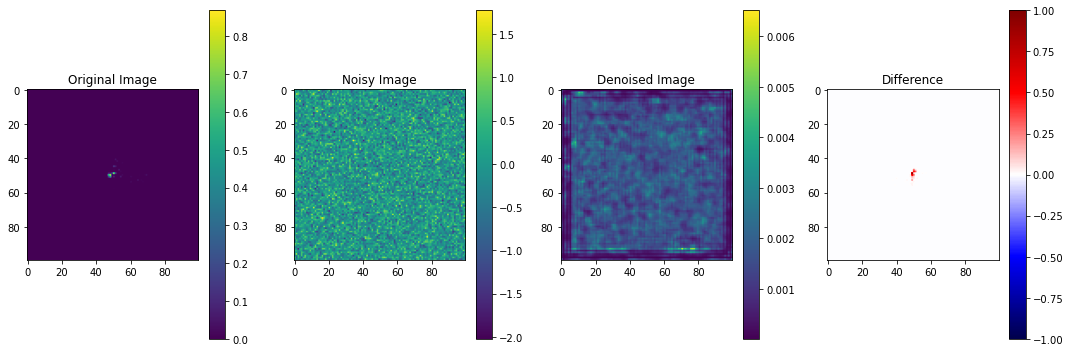

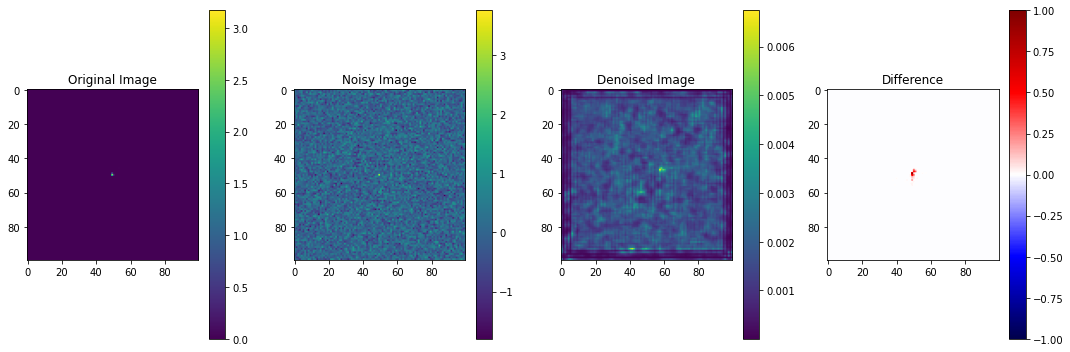

In [18]:

# Denoise some sample images. 
num_samples = 5
sample_indices = np.random.randint(0, len(noisy_jet_images_reshaped), num_samples)
sample_noisy_images = noisy_jet_images_reshaped[sample_indices]
sample_denoised_images = autoencoder.predict(sample_noisy_images)

# Display original, noisy, denoised images, and difference with custom colormap
for i in range(num_samples):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 4, 1)
    plt.imshow(jet_images_reshaped[sample_indices[i]].reshape((image_size, image_size)), cmap='viridis')
    plt.title('Original Image')
    plt.colorbar()

    plt.subplot(1, 4, 2)
    plt.imshow(noisy_jet_images_reshaped[sample_indices[i]].reshape((image_size, image_size)), cmap='viridis')
    plt.title('Noisy Image')
    plt.colorbar()

    plt.subplot(1, 4, 3)
    plt.imshow(sample_denoised_images[i].reshape((image_size, image_size)), cmap='viridis')
    plt.title('Denoised Image')
    plt.colorbar()

    plt.subplot(1, 4, 4)
    # Display a specific slice of the difference array (e.g., the middle slice)
    middle_slice = difference[:,:,difference.shape[2]//2]
    plt.imshow(middle_slice, cmap='seismic', vmin=-1, vmax=1)  # Customizing the colormap and range
    plt.title('Difference')
    plt.colorbar()

    plt.tight_layout()
    plt.show()
